This is a notebook for training a MNIST frequentist model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from torch import save as save_state_dict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 10

# Data loaders
There are several datasets available for digit (and letter) classification. Standard is MNIST. There is also EMNIST, also has letters. There is QMNIST which is basically MNIST but larger.

We will also here use data augmentation (transforms.RandomAffine) in order for the model to generalize better. Note that we apply the data augmentation to training aswell as validation data.

In [88]:
def get_data_loaders(split='digits'):
    transform = transforms.Compose([
        #transforms.RandomAffine(degrees=30, translate=(0.2, 0.2), scale=(0.7, 1.2)),
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.EMNIST(
        root='/storage',
        split=split,
        train=True,
        download=True,
        transform=transform,
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=100,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    testset = torchvision.datasets.EMNIST(
        root='/storage',
        split=split,
        train=False,
        download=True,
        transform=transform,
    )

    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=100,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    return trainloader, testloader

Make som plots to see how data augmentation works

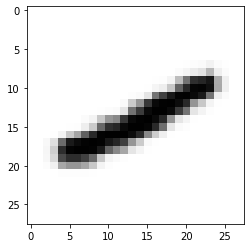

In [97]:
def plot_data_augmentation():
    train_loader, _ = get_data_loaders('letters')
    for data, labels in train_loader:
        sample = data[0, :, :, :].view(28, 28).numpy()
        plt.imshow(sample, cmap='Greys')
        plt.show()
        break
plot_data_augmentation()

# Metrics
Define some metrics so we have an easy way to measure accuracy.

In [ ]:
def loader_accuracy(loader, model):
    with torch.no_grad():
        cum_acc = 0
        for x, y in loader:
            cum_acc += accuracy(x.to(DEVICE), y.to(DEVICE), model)
        return cum_acc / len(loader)


def accuracy(x, y, model):
    with torch.no_grad():
        pred = model(x).argmax(dim=1, keepdim=True)
        corrects = pred.eq(y.view_as(pred)).sum().item()
        acc = corrects * 100 / len(x)
        return acc

# Model
Here is our model. It is quite complex, but since we usse quite aggressive data augmentation, we run little risk of overtrainng.

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.arch = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1),
            nn.MaxPool2d(2),

            # 4x4 image

            Flatten(),
            nn.Linear(64*4*4, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return F.log_softmax(self.arch(x), dim=1)

Here is our main training loop. It also produces some nice plots when it is done :)

In [ ]:
def create_model(epochs=20, optim=torch.optim.Adam, lr=1e-3):
    model = CNN()
    model.to(DEVICE)
    
    losses = []
    val_accs = []
    train_accs = []
    
    train_loader, test_loader = get_data_loaders()
    optim = optim(model.parameters(), lr=lr)
    for epoch in range(epochs):
        total_loss = 0
        for data, labels in train_loader:
            preds = model(data.to(DEVICE))
            loss = F.cross_entropy(preds, labels)
            loss.backward()
            optim.step()
            optim.zero_grad()
            total_loss += loss.item() / len(labels)
            
        # Multiply loss by 100 to make it more relatable. NB: This is not a best practice
        total_loss *= 100/len(train_loader)
        losses.append(total_loss)
        val_acc = loader_accuracy(test_loader, model)
        val_accs.append(val_acc)
        train_acc = loader_accuracy(train_loader, model)
        train_accs.append(train_acc)
        
        print(f'EPOCH {epoch+1}, validation accuracy {val_acc:.2f}% loss {total_loss:.2f}')
    
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Training')
    plt.plot(val_accs, label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Validation')
    
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training loss')
    plt.show()
    
    return model

Now actually create and train a model.

In [ ]:
model = create_model(epochs=10)

# Save it
Save model statedict so we can use it elsewhere.

In [ ]:
def save(model, path='mnist.pt'):
    save_state_dict(model.state_dict(), path)

In [ ]:
save(model)